# Reducción de dimensión con PCA (basada en SVD)

En este notebook vamos a:

1. Ver la relación entre SVD y PCA e implementar PCA “a mano” usando SVD.
2. Visualizar un ejemplo geométrico en 2D.
3. Aplicar PCA a datos de mayor dimensión y analizar la varianza explicada.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
np.random.seed(0)

### 1. PCA y su relación con SVD

Dado un conjunto de datos 
$
X \in \mathbb{R}^{d \times n},
$
donde cada columna es una observación en $\mathbb{R}^d$, definimos:

1. La media:
$
\boldsymbol{\mu} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i
$

2. La matriz centrada:
$
\overline{X} = X - \boldsymbol{\mu}[1,\dots,1]
$

Si aplicamos la descomposición en valores singulares a $\overline{X}$:

$
\overline{X} = U \Sigma V^\top,
$

entonces:

- Las **direcciones principales (componentes principales)** son las columnas de $U$.
- Los **autovalores** de la matriz de covarianza son $\lambda_i = \sigma_i^2 / (n-1)$.
- La proyección de los datos en las primeras $k$ componentes principales es:
$
\Phi_k = U_k^\top \overline{X}
$

donde $U_k$ contiene las primeras $k$ columnas de $U$.


In [3]:
def pca_svd(X, k=None):
    """
    PCA usando SVD.
    
    X: array de tamaño (n_muestras, n_features)
    k: número de componentes principales a conservar (si None, se usan todas)
    
    Devuelve:
        X_mean: media de los datos (n_features,)
        U_k: componentes principales (n_features, k)
        s: valores singulares (ordenados de mayor a menor)
        Z: proyecciones de los datos sobre las primeras k componentes (n_muestras, k)
    """
    # X como (d, n) para seguir la notación de los otros notebooks
    X = np.asarray(X)
    n_samples, n_features = X.shape
    
    # Centramos las filas (muestras) restando la media de cada feature
    X_mean = X.mean(axis=0)
    X_centered = X - X_mean
    
    # Transponemos para trabajar con columnas = observaciones (d x n)
    Xc_T = X_centered.T  # (d, n)
    
    # SVD de la matriz centrada
    U, s, VT = np.linalg.svd(Xc_T, full_matrices=False)
    
    if k is None:
        k = U.shape[1]
    U_k = U[:, :k]                     # (d, k)
    
    # Proyecciones de los datos (n_muestras, k)
    # X_centered: (n, d), U_k: (d, k)
    Z = X_centered @ U_k               # (n, k)
    
    return X_mean, U_k, s, Z


### 2. Ejemplo geométrico en 2D

Generamos datos en 2D alargados en una dirección (varianza grande) y comprimidos en la otra (varianza pequeña).


In [4]:
# Parámetros del ejemplo 2D
theta = np.pi / 6  # ángulo de la "dirección principal"
v1 = np.array([np.cos(theta), np.sin(theta)])  # dirección de mayor varianza
v2 = np.array([-np.sin(theta), np.cos(theta)]) # dirección ortogonal

rho1 = 12.0  # escala en la dirección v1 (varianza grande)
rho2 =  3.0  # escala en la dirección v2 (varianza pequeña)
n_points = 1000

b = np.array([2.0, -1.0])  # centro

# Generamos datos: combinación lineal de v1 y v2 + traslación
seeds = np.random.randn(2, n_points) # genera n_points muestras de N(0,1) en 2D
X2 = b[:, None] + rho1 * np.outer(v1, seeds[0, :]) + \
                 rho2 * np.outer(v2, seeds[1, :]) # asignamos a las muestras las direcciones v1 y v2 con sus escalas
X2 = X2.T  # (n_points, 2)

X2.shape


(1000, 2)

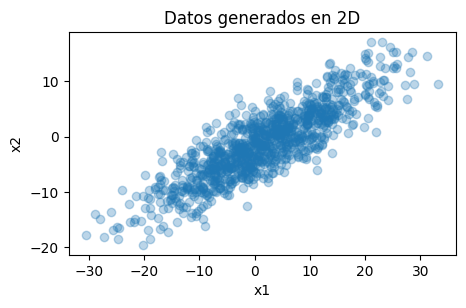

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X2[:, 0], X2[:, 1], alpha=0.3)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Datos generados en 2D")
ax.set_aspect('equal')
plt.show()


Aplicamos PCA usando SVD con 2 componentes principales para encontrar las direcciones principales y proyectar los datos.

In [6]:
X_mean_2d, U_2d, s_2d, Z_2d = pca_svd(X2, k=2)

print("Media:", X_mean_2d, ", próxima al centro real b:", b)
print("Componentes principales (columnas de U_2d):")
print(U_2d)
print("Valores singulares:", s_2d)


Media: [ 1.50925309 -1.2361624 ] , próxima al centro real b: [ 2. -1.]
Componentes principales (columnas de U_2d):
[[-0.87010612 -0.49286442]
 [-0.49286442  0.87010612]]
Valores singulares: [374.56464324  91.79920225]


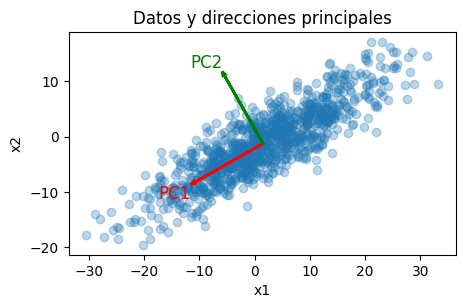

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X2[:, 0], X2[:, 1], alpha=0.3)

# Punto medio
mu = X_mean_2d

# Dibujamos vectores de las componentes principales
scale = 15.0
for i in range(2):
    vec = U_2d[:, i]
    ax.arrow(mu[0], mu[1], scale * vec[0], scale * vec[1],
             head_width=0.5, color='red' if i == 0 else 'green',
             length_includes_head=True, linewidth=2)
    ax.text(mu[0] + scale * vec[0], mu[1] + scale * vec[1],
            f'PC{i+1}', color='red' if i == 0 else 'green',
            fontsize=12,
            verticalalignment='bottom' if vec[1] >= 0 else 'top',
            horizontalalignment='right' if vec[0] <= 0 else 'left')

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Datos y direcciones principales")
ax.set_aspect('equal')
plt.show()


### Proyección a 1D y reconstrucción aproximada

Ahora proyectamos los datos sobre la **primera componente principal** (PC1) y reconstruimos una aproximación en 2D usando solo esa dimensión.


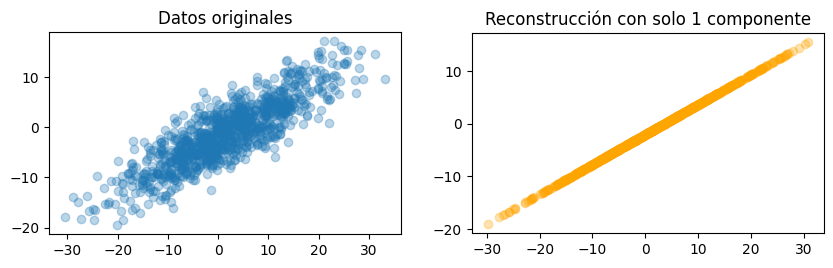

In [8]:
# Usamos solo la primera componente principal
k1 = 1
U1_2d = U_2d[:, :k1]          # (2,1)
Z1_2d = Z_2d[:, :k1]          # (n,1)

# Reconstrucción aproximada en 2D
X2_recon = Z1_2d @ U1_2d.T + X_mean_2d  # (n,2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(X2[:, 0], X2[:, 1], alpha=0.3)
axs[0].set_title("Datos originales")
axs[0].set_aspect('equal')

axs[1].scatter(X2_recon[:, 0], X2_recon[:, 1], alpha=0.3, color='orange')
axs[1].set_title("Reconstrucción con solo 1 componente")
axs[1].set_aspect('equal')

plt.show()

### 3. PCA en dimensión más alta

Usando el dataset `mnist`, el cual contiene imágenes de dígitos escritos a mano (28x28 píxeles, es decir, 784 dimensiones), aplicamos PCA para reducir la dimensión y analizar la varianza explicada. Además crearemos un clasificador binario simple para distinguir entre dos dígitos (por ejemplo, '0' y '9') usando las primeras $k$ componentes principales.


In [9]:
data = np.genfromtxt("data/mnist_train_small.csv", delimiter=",")
data.shape


(20000, 785)

Almacenamos en un vector las imagenes y en otro las etiquetas correspondientes.

In [10]:
labels = data[:, 0]
A = data[:, 1:].transpose()
labels.shape, A.shape

((20000,), (784, 20000))

Visualizamos las primeras 30 imágenes originales con sus etiquetas.

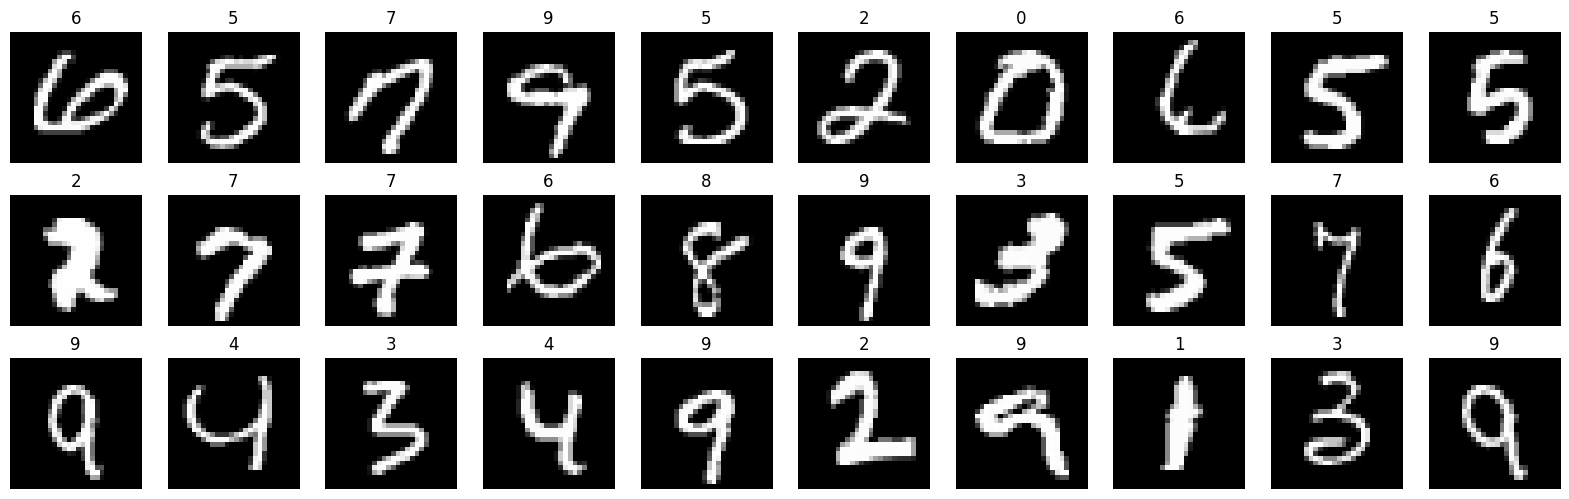

In [11]:
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 6))
axs = axs.reshape((-1,))
for i in range(30):
    image_i = A[:, i].reshape((28, 28))
    axs[i].imshow(image_i, cmap="gray")
    axs[i].set_title(int(labels[i]))
    axs[i].axis("off")

Visualizamos las primeras 30 imágenes correspondientes a la etiqueta "4":

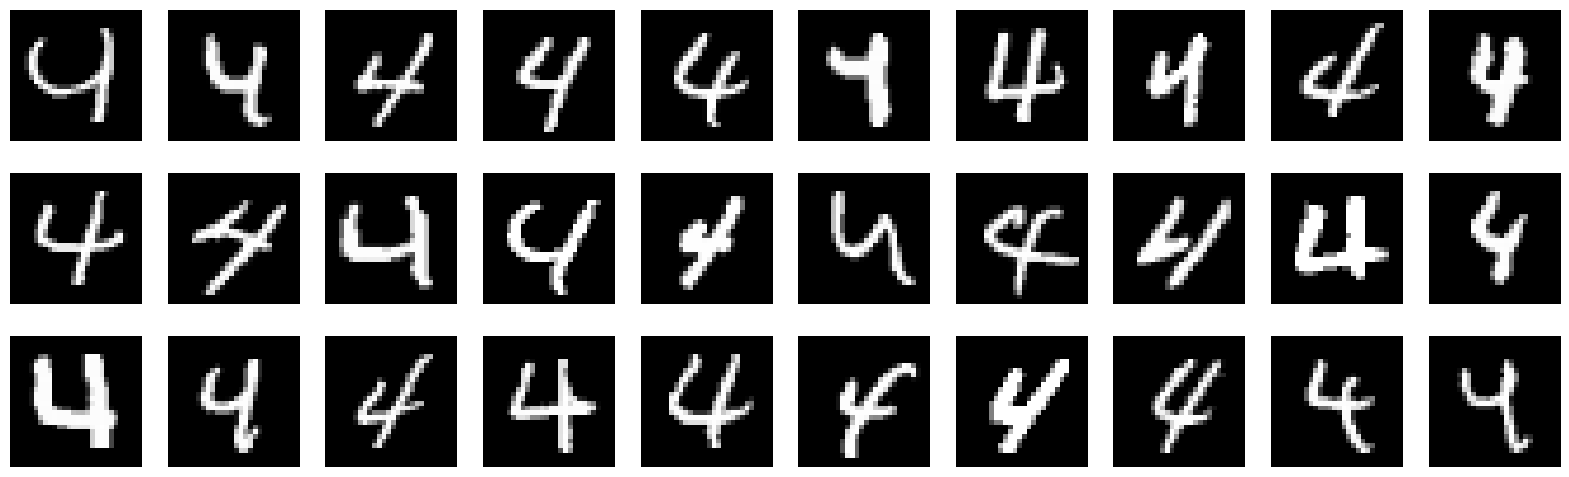

In [12]:
A_filtered = A[:, labels == 4]
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 6))
axs = axs.reshape((-1,))
for i in range(30):
    image_i = A_filtered[:, i].reshape((28, 28))
    axs[i].imshow(image_i, cmap="gray")
    axs[i].axis("off")

Aplicamos PCA usando SVD para la visualización de los datos del conjunto digits proyectados sobre las dos primeras componentes principales (los vectores singulares derechos $V$). Se observa la agrupación natural de los dígitos en el espacio reducido. Nótese que dígitos como el 0, el 1 y el 9 están bien separados, mientras que otros como el 2, el 8 y el 6 tienden a superponerse más, ya que tienen formas más similares.

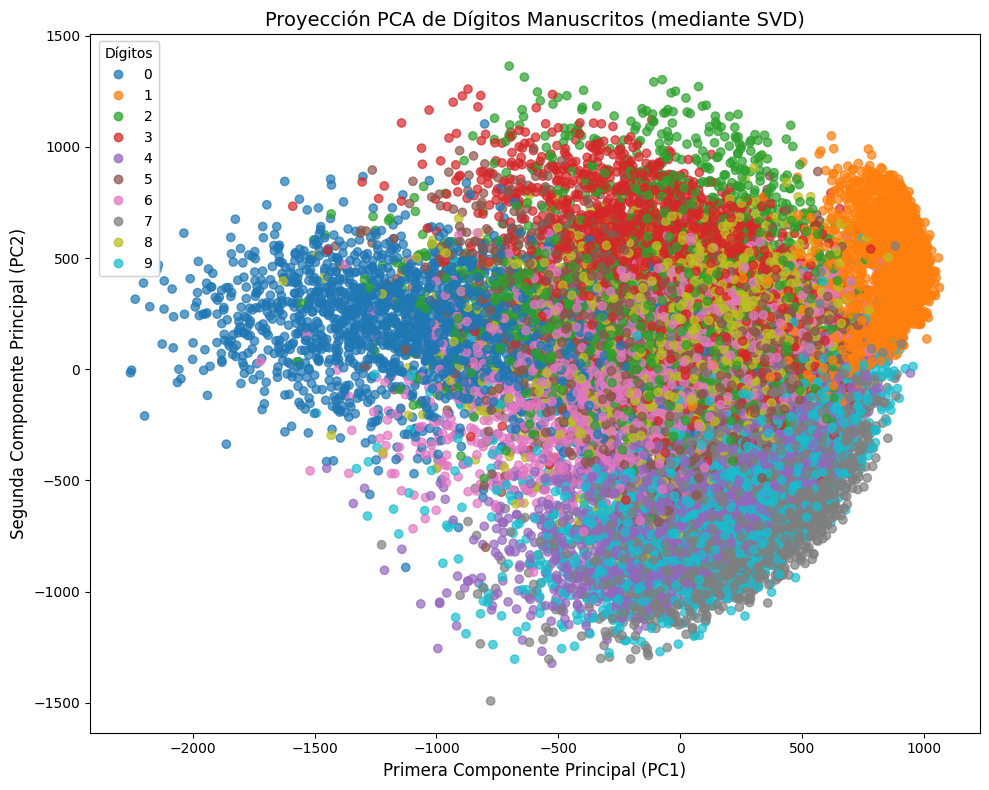

In [13]:
A_mean = A.mean(axis=1)
A_bar = A - A_mean[:, None]
X, U, s, V = pca_svd(A_bar.T, k=2)

fig, ax = plt.subplots(figsize=(10, 8)) # Aumentamos ligeramente el tamaño para el ajuste
scatter = ax.scatter(V[:, 0], V[:, 1], c=labels, cmap='tab10', alpha=0.7)

# 1. Añadir Título y Etiquetas de Ejes para claridad
ax.set_title('Proyección PCA de Dígitos Manuscritos (mediante SVD)', fontsize=14)
ax.set_xlabel('Primera Componente Principal (PC1)', fontsize=12)
ax.set_ylabel('Segunda Componente Principal (PC2)', fontsize=12)

# 2. Crear y añadir la Leyenda
legend1 = ax.legend(*scatter.legend_elements(),
                    title="Dígitos",
                    loc="upper right", 
                    bbox_to_anchor=(0.085, 1), # Coloca la leyenda fuera del plot
                    prop={'size': 10}) # Ajusta el tamaño de la fuente de la leyenda
ax.add_artist(legend1)

# 3. Ajustar el diseño para prevenir el recorte de la leyenda
plt.tight_layout() 

# plt.savefig('pca_digits_svd_con_leyenda.png') 
plt.show()

### Clasificación binaria entre 2 dígitos
Tomaremos los numeros "0" y "9" para construir un dataset de training reducido.

In [14]:
digits = (0, 9)
mask = np.logical_or(labels == digits[0], labels == digits[1])
A = A[:, mask]
labels = labels[mask]

Visaulizamos la media de nuestras imágenes.

(-0.5, 27.5, 27.5, -0.5)

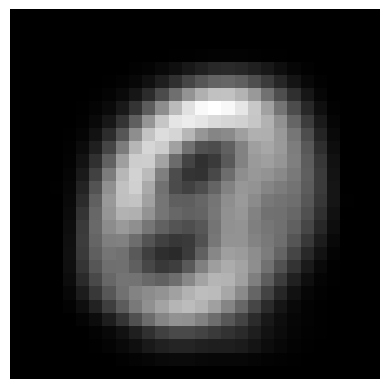

In [15]:
A_mean = A.mean(axis=1)
plt.imshow(A_mean.reshape((28, 28)), cmap="gray")
plt.axis("off")

Aplicando $SVD$ con `np.linalg.svd`, graficamos la tendencia de:
- Los valores singulares $\sigma_k$
- la fracción acumulada de valores singulares: $\frac{\sum_{i=1}^{k} \sigma_i}{\sum_{i=1}^{q} \sigma_i}$
- la fracción de la "varianza explicada": $\frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{q} \sigma_i^2}$

Text(0.5, 1.0, 'Varianza explicada')

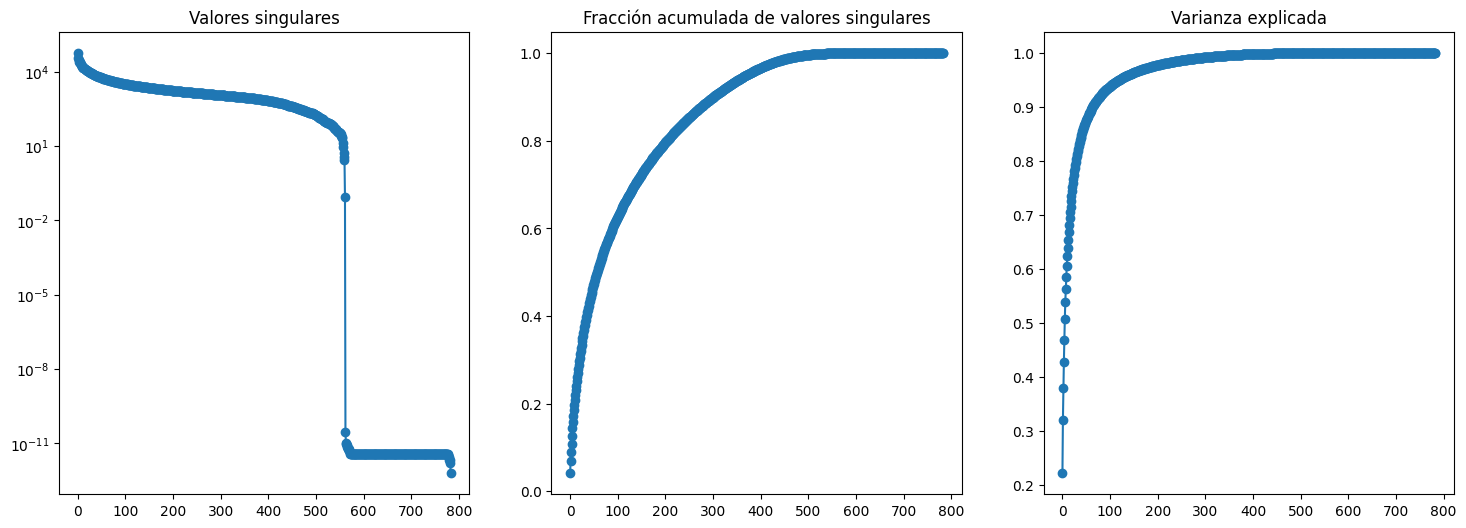

In [16]:
A_bar = A - A_mean[:, None]
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].semilogy(s, "o-")
axes[0].set_title("Valores singulares")

axes[1].plot(np.cumsum(s) / np.sum(s), "o-")
axes[1].set_title("Fracción acumulada de valores singulares")

axes[2].plot(np.cumsum(s**2) / np.sum(s**2), "o-")
axes[2].set_title("Varianza explicada")

Visualizamos las primeras 30 componentes principales como imágenes.

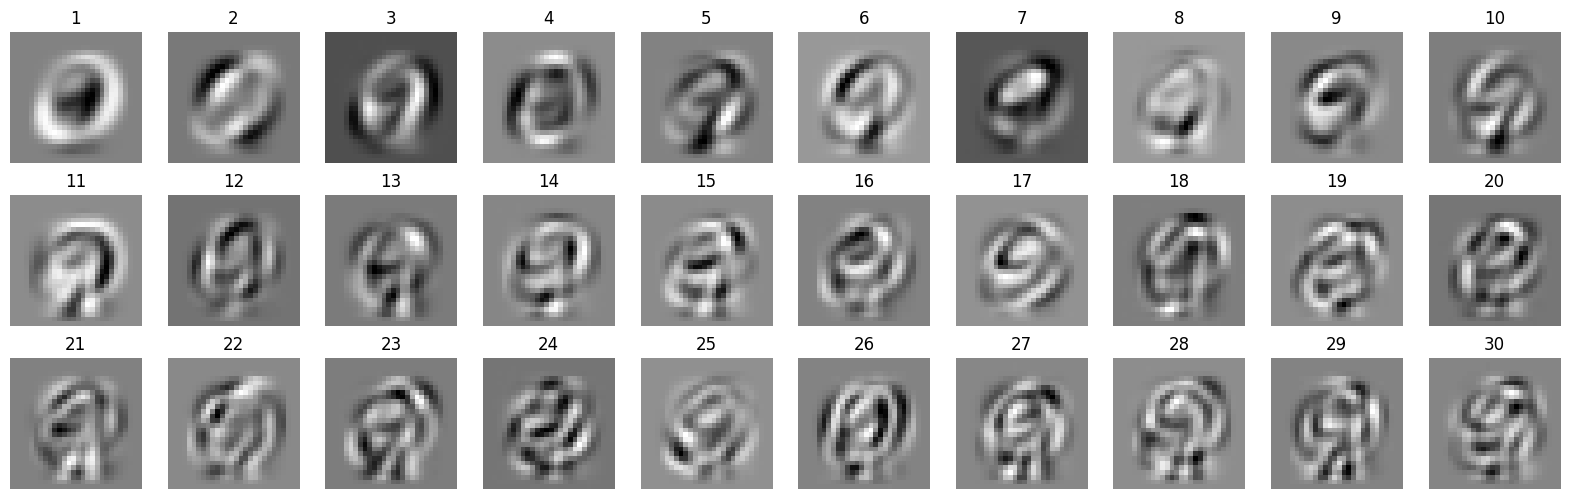

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
axs = axs.reshape((-1,))
for i in range(len(axs)):
    image_i = U[:, i].reshape((28, 28))
    axs[i].imshow(image_i, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(str(i + 1))

Se puede intuír la silueta de ambos dígitos en las componentes principales.

Definimos una matriz que contiene las componentes principales de todas las imágenes

In [18]:
A_pc = np.matmul(U.T, A_bar)
print(f"Primera componente principal: {A_pc[0, 0]}")
print(f"Segunda componente principal: {A_pc[1, 0]}")

Primera componente principal: -529.0964148086612
Segunda componente principal: -580.860850162436


Hacemos un scatter plot de las primeras dos componentes principales, coloreando según la etiqueta.

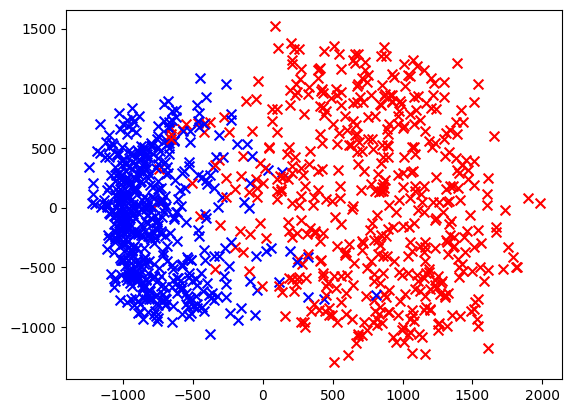

In [19]:
for i in range(1000):
    x = np.inner(A_bar[:, i], U[:, 0])
    y = np.inner(A_bar[:, i], U[:, 1])
    col = "r" if labels[i] == digits[0] else "b"
    plt.scatter(x, y, marker="x", color=col, s=50)

Definimos un claificador, fijando un umbral en la primera componente principal.

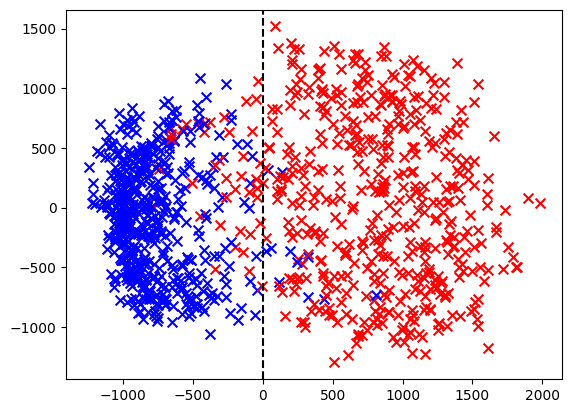

In [20]:
threshold = 0

for i in range(1000):
    x = np.inner(A_bar[:, i], U[:, 0])
    y = np.inner(A_bar[:, i], U[:, 1])
    col = "r" if labels[i] == digits[0] else "b"
    plt.scatter(x, y, marker="x", color=col, s=50)

plt.axvline(threshold, color="k", linestyle="--")

Ahora probamos el clasificador en el conjunto de datos de test.

In [21]:
test = np.genfromtxt("data/mnist_test.csv", delimiter=",")
labels_test = test[:, 0]
A_test = test[:, 1:].transpose()
labels_test.shape, A_test.shape

((10000,), (784, 10000))

In [22]:
mask = np.logical_or(labels_test == digits[0], labels_test == digits[1]) # filtrar solo los dígitos de interés
A_test = A_test[:, mask]
labels_test = labels_test[mask]
labels_test.shape, A_test.shape

((1989,), (784, 1989))

Graficamos las primeras dos componentes principales del conjunto de test, coloreando según la etiqueta real y mostrando el umbral del clasificador.

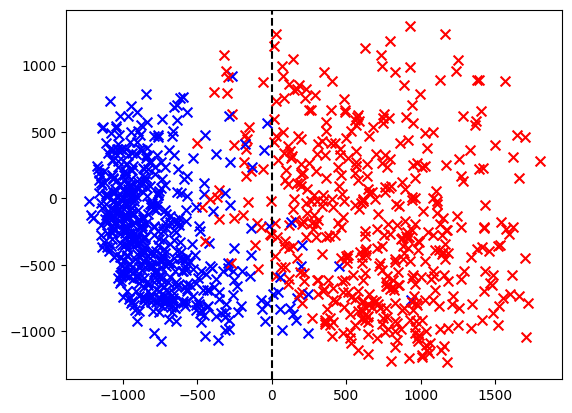

In [23]:
A_test_mean = A_test.mean(axis=1)
A_test_bar = A_test - A_test_mean[:, None] # Muestras del conjunto de test centradas en torno a su media propia

for i in range(1000):
    x = np.inner(A_test_bar[:, i], U[:, 0])
    y = np.inner(A_test_bar[:, i], U[:, 1])
    col = "r" if labels_test[i] == digits[0] else "b"
    plt.scatter(x, y, marker="x", color=col, s=50)

plt.axvline(threshold, color="k", linestyle="--")

In [24]:
PC_1 = np.matmul(U[:, 0].transpose(), (A_test - A_mean[:, None])) # proyecciones sobre la primera componente principal. Usamos U del conjunto de entrenamiento

labels_predicted = np.empty(labels_test.shape).astype(int)
labels_predicted[PC_1 > threshold] = digits[0]
labels_predicted[PC_1 <= threshold] = digits[1]

true_0 = np.sum(np.logical_and(labels_test == digits[0], labels_predicted == digits[0]))
false_0 = np.sum(
    np.logical_and(labels_test == digits[1], labels_predicted == digits[0])
)
true_1 = np.sum(np.logical_and(labels_test == digits[1], labels_predicted == digits[1]))
false_1 = np.sum(
    np.logical_and(labels_test == digits[0], labels_predicted == digits[1])
)

print(f"Verdaderos {digits[0]}: {true_0}")
print(f"Falsos {digits[0]}: {false_0}")
print(f"Verdaderos {digits[1]}: {true_1}")
print(f"Falsos {digits[1]}: {false_1}")
accuracy = (true_0 + true_1) / (true_0 + true_1 + false_0 + false_1)
print(f"Precisión = {accuracy * 100:.2f} %")

Verdaderos 0: 927
Falsos 0: 30
Verdaderos 9: 979
Falsos 9: 53
Precisión = 95.83 %


C:\Users\migue\AppData\Local\Temp\ipykernel_34848\1497532572.py:3: RuntimeWarning: invalid value encountered in cast
  labels_predicted = np.empty(labels_test.shape).astype(int)


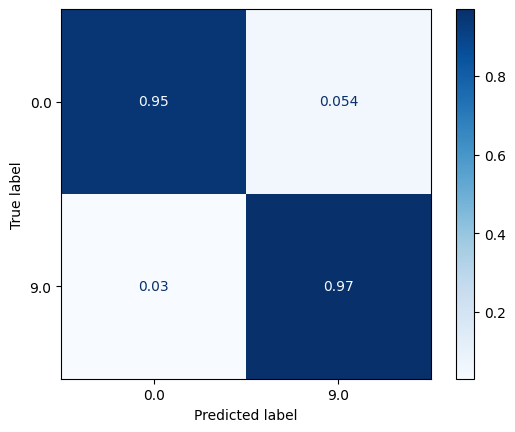

In [25]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    labels_test, labels_predicted, cmap=plt.cm.Blues, normalize="true",
)

## 4. Conclusiones

1. **Relación SVD–PCA**:  
   Hemos visto que PCA se puede implementar directamente a partir de la SVD de la matriz de datos centrada.  
   Las columnas de $U$ son las direcciones principales y los cuadrados de los valores singulares (escalados por $1/(n-1)$) corresponden a los autovalores de la matriz de covarianza.

2. **Interpretación geométrica en 2D**:  
   En el ejemplo de 2D, las componentes principales capturan la dirección de mayor varianza de los datos.  
   Al proyectar sobre la primera componente y reconstruir, obtenemos una aproximación “aplastada” sobre una recta, que retiene la estructura principal pero pierde información en la dirección de menor varianza.

3. **Reducción de dimensión en alta dimensión**:  
   En el ejemplo de `mnist`, PCA nos permitió reducir la dimensión de las imágenes de 784 a unas pocas decenas de componentes principales, capturando la mayoría de la varianza.  
   Esto facilita la visualización y el análisis, además de mejorar la eficiencia computacional. Además, el clasificador simple basado en las dos primeras componentes principales mostró un rendimiento razonable, demostrando que PCA puede ser útil para tareas de clasificación al reducir el ruido y resaltar las características relevantes de los datos